# Mental Health Sentiment Chatbot Application

## Installing libraries, dependencies, and data

In [1]:
# Import the required libraries and dependencies
import pandas as pd
from matplotlib import pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI
from langchain import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

import gradio as gr

# Set the column width to view the statments.
pd.set_option('max_colwidth', 200)

In [2]:
# Load the dataset.
df = pd.read_csv("Combined_Data.csv", index_col="Unnamed: 0")
# Display a sample of the dataset. 
df.sample(5)

,statement,status
24933,I am just tired of being here and the people on this world. My friend got killed over a fight before he could even finish high school. I have seen a dude with part of his brain and head blown out....,Suicidal
40896,content by eugene cacao graphic by kath limfueco source holland k 0 september how to fight depression 0 thing to try healthline http t co o udqteja what is depression n d american psychiatric asso...,Depression
38002,ha anyone been prescribed mirtazapine or other alpha receptor antagonist to treat their anxiety i would prefer not to use start with ssri s what wa you experience,Depression
33799,my brother smokes three packs a day.,Normal
1857,"At the age of 25, I am still strong in living my life with all its problems. Thank God",Normal


## Data Cleanup and Preparation

In [3]:
# Check for missing values. 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [4]:
# Null values in the statement column
df['statement'].notnull().value_counts()

statement
True     52681
False      362
Name: count, dtype: int64

In [5]:
# Drop null values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
# Get the number of different statuses in the status column:
status_count = df['status'].value_counts()
status_count

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

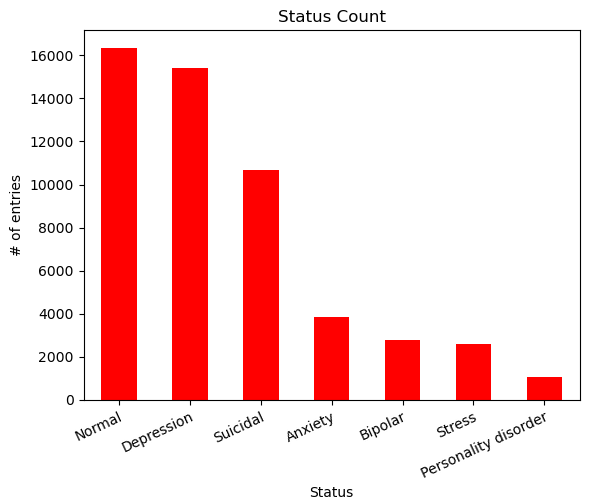

In [7]:
status_chart = status_count.plot(
    kind='bar',
    facecolor='r',
    title='Status Count',
    xlabel='Status',
    ylabel='# of entries'
)
ticks = status_count.index
status_chart.set_xticklabels(ticks, rotation=25, rotation_mode='anchor', ha='right', wrap=True)
plt.show()

In [8]:
# Turning the statement column to a list.
statements = df['statement'].to_list()
statements

['oh my gosh',
 'trouble sleeping, confused mind, restless heart. All out of tune',
 'All wrong, back off dear, forward doubt. Stay in a restless and restless place',
 "I've shifted my focus to something else but I'm still worried",
 "I'm restless and restless, it's been a month now, boy. What do you mean?",
 'every break, you must be nervous, like something is wrong, but what the heck',
 'I feel scared, anxious, what can I do? And may my family or us be protected :)',
 "Have you ever felt nervous but didn't know why?",
 "I haven't slept well for 2 days, it's like I'm restless. why huh :([].",
 "I'm really worried, I want to cry.",
 "always restless every night, even though I don't know why, what's wrong. strange.",
 "I'm confused, I'm not feeling good lately. Every time I want to sleep, I always feel restless",
 'sometimes what is needed when there is a problem is to laugh until you forget that there is a problem, when you remember it, you feel restless like that well, it turns out th

In [9]:
# Using the analyzer to determine the sentiment of each statement.
sentiment = []
score = []
analyzer = SentimentIntensityAnalyzer()
for statement in statements:
    statement_sentiment = analyzer.polarity_scores(statement)
    if statement_sentiment['compound'] >= 0.05:
        sentiment.append("Positive")
 
    elif statement_sentiment['compound'] <= - 0.05:
        sentiment.append("Negative")
 
    else:
        sentiment.append("Neutral")
    score.append(statement_sentiment['compound'])

In [10]:
# Creating sentiment and score columns.
df['sentiment'] = sentiment
df['score'] = score
df.head()

,statement,status,sentiment,score
0,oh my gosh,Anxiety,Neutral,0.0000
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety,Negative,-0.2263
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety,Negative,-0.7351
3,I've shifted my focus to something else but I'm still worried,Anxiety,Negative,-0.4215
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety,Negative,-0.4939


In [11]:
# Displaying a sample of the new DataFrame.
df.sample(10)

,statement,status,sentiment,score
21397,"The person who supposedly is there for me is not. My family only cares for me when it comes to ask for a service or a favour, and they do not really care for me, whether it would be successes or w...",Suicidal,Negative,-0.9676
30924,"yes, i do.",Normal,Positive,0.4019
3825,"It's gastric in the morning, we're not joking huh",Normal,Negative,-0.1695
36537,@SamanthaPaige3 This is the best thing to pop on my Twitter all dayðð what cracks me up is that billy is in it tooððð,Normal,Positive,0.6369
47352,I’ve recently been getting closer to reaching proper nutrition everyday and it’s made more of an improvement than any antidepressant I’ve ever been put on has the more I learned about nutrition th...,Depression,Positive,0.7821
36573,"@slxmdunk,United Kingdom,@Pamaj what hapens if i dont want to be here anymore?",Suicidal,Negative,-0.0572
15807,"I do not really know why I am writing about this but we all know that it is obvious.I just feel like I am forced to live dealing with other people's shit every single day,it is fucking tiring.I do...",Depression,Negative,-0.9928
18290,**Extraterrestrial beings can visit our planet in a few days.** Extraterrestrial beings can visit our planet in a few days.,Depression,Neutral,0.0000
45049,im trying to make a chicken soup like my mother but without a recipe this will be interesting and i cant find matzah,Normal,Positive,0.6486
2535,lexi pspspspspspsps,Normal,Neutral,0.0000


In [12]:
# Get the number of different results in the sentiment column:
sentiment_count = df['sentiment'].value_counts()
sentiment_count

sentiment
Negative    28780
Positive    17394
Neutral      6507
Name: count, dtype: int64

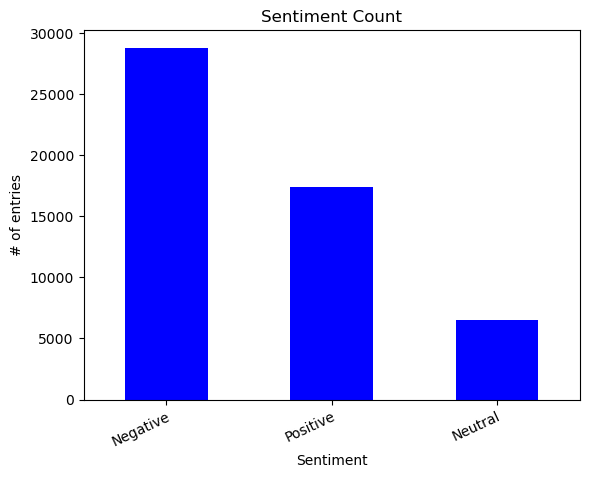

In [13]:
sentiment_chart = sentiment_count.plot(
    kind='bar',
    facecolor='b',
    title='Sentiment Count',
    xlabel='Sentiment',
    ylabel='# of entries'
)
ticks = sentiment_count.index
sentiment_chart.set_xticklabels(ticks, rotation=25, rotation_mode='anchor', ha='right', wrap=True)
plt.show()

In [14]:
# Set the features variable.
X = df['statement']
# Set the target variables.
y_status = df['status']
y_sentiment = df['sentiment']

In [15]:
# Split data into training and testing for status
X_status_train, X_status_test, y_status_train, y_stauts_test = train_test_split(X, y_status, test_size=0.25, random_state=1)

In [16]:
# Split data into training and testing for sentiment
X_sentiment_train, X_sentiment_test, y_sentiment_train, y_sentiment_test = train_test_split(X, y_sentiment, test_size=0.30, random_state=1)

## ML Model

Title: y_status_train

In [17]:
status_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('classifier', LinearSVC())
])

status_pipeline.fit(X_status_train, y_status_train)

# Print the results
status_predictions = status_pipeline.predict(X_status_test)
print(status_predictions)


c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


['Depression' 'Normal' 'Bipolar' ... 'Normal' 'Depression' 'Normal']


In [18]:
# Show the test data and corresponding predictions
stauts_test_results = pd.DataFrame({'X_test': X_status_test, 'Predicted_y': status_predictions, 'Actual_y': y_stauts_test})
print(stauts_test_results)

                                                                                                                                                                                                        X_test  \
39488  i m and i have bad anxiety debilitating i haven t been able to keep a job since i wa so pretty much ever i wake up early morning hour before i have to be my heart race i black out i puke cough my ...   
1480                                                                                                               Jessica starred in the musical "Legally Blonde" as Elle Woods, the female lead in the drama   
47948  I’m so tired I just don’t see a point to my suffering, I don’t understand it, I want to know what I’ve done so wrong to deserve everything, I’d say sorry and do anything to make it stop! I already...   
19681  My life 1 year ago was completely different. I was such a chick magnet and everyone loved me i had so many friends and in this past year i lost everythin

In [19]:
# Validate the model by checking the model's training and testing accuracy.
training_accuracy = status_pipeline.score(X_status_train, y_status_train)
testing_accuracy = status_pipeline.score(X_status_test, y_stauts_test)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.9328524424196406
Testing Accuracy: 0.783387745805178


In [20]:
# Create the confusion matrix
confusion_mat = confusion_matrix(y_stauts_test, status_predictions)

# Print the confusion matrix
print("Status Confusion Matrix:")
print(confusion_mat)

# Print a classification report
print("Status Classification Report:")
print(classification_report(y_stauts_test, status_predictions))

# Print the overall accuracy
accuracy = accuracy_score(y_stauts_test, status_predictions)
print("Overall Accuracy:", accuracy)

Status Confusion Matrix:
[[ 745    6   97   60    6   23    6]
 [  17  509   77   36    3   16   13]
 [  62   36 2810  149   10   27  785]
 [  27    7   95 3907    1   50   50]
 [   3    6   62   18  155   14   12]
 [  53   14  108   86    7  331   22]
 [  11    7  663   98    2    8 1861]]
Status Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.81      0.79      0.80       943
             Bipolar       0.87      0.76      0.81       671
          Depression       0.72      0.72      0.72      3879
              Normal       0.90      0.94      0.92      4137
Personality disorder       0.84      0.57      0.68       270
              Stress       0.71      0.53      0.61       621
            Suicidal       0.68      0.70      0.69      2650

            accuracy                           0.78     13171
           macro avg       0.79      0.72      0.75     13171
        weighted avg       0.78      0.78      0.78     

Title: y_sentiment_train

In [21]:
sentiment_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('classifier', LinearSVC())
])

sentiment_pipeline.fit(X_sentiment_train, y_sentiment_train)

# Print the results
sentiment_predictions = sentiment_pipeline.predict(X_sentiment_test)
print(sentiment_predictions)


c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


['Positive' 'Positive' 'Negative' ... 'Negative' 'Neutral' 'Negative']


In [22]:
# Show the test data and corresponding predictions
sentiment_test_results = pd.DataFrame({'X_test': X_sentiment_test, 'Predicted_y': sentiment_predictions, 'Actual_y': y_sentiment_test})
print(sentiment_test_results)

                                                                                                                                                                                                        X_test  \
39488  i m and i have bad anxiety debilitating i haven t been able to keep a job since i wa so pretty much ever i wake up early morning hour before i have to be my heart race i black out i puke cough my ...   
1480                                                                                                               Jessica starred in the musical "Legally Blonde" as Elle Woods, the female lead in the drama   
47948  I’m so tired I just don’t see a point to my suffering, I don’t understand it, I want to know what I’ve done so wrong to deserve everything, I’d say sorry and do anything to make it stop! I already...   
19681  My life 1 year ago was completely different. I was such a chick magnet and everyone loved me i had so many friends and in this past year i lost everythin

In [23]:
# Validate the model by checking the model's training and testing accuracy.
training_accuracy = sentiment_pipeline.score(X_sentiment_train, y_sentiment_train)
testing_accuracy = sentiment_pipeline.score(X_sentiment_test, y_sentiment_test)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.946415012474238
Testing Accuracy: 0.8268269534957292


In [24]:
# Create the confusion matrix
confusion_mat = confusion_matrix(y_sentiment_test, sentiment_predictions)

# Print the confusion matrix
print("Sentiment Confusion Matrix:")
print(confusion_mat)

# Print a classification report
print("Sentiment Classification Report:")
print(classification_report(y_sentiment_test, sentiment_predictions))

# Print the overall accuracy
accuracy = accuracy_score(y_sentiment_test, sentiment_predictions)
print("Overall Accuracy:", accuracy)

Sentiment Confusion Matrix:
[[7683  206  813]
 [ 253 1389  269]
 [ 999  197 3996]]
Sentiment Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      8702
     Neutral       0.78      0.73      0.75      1911
    Positive       0.79      0.77      0.78      5192

    accuracy                           0.83     15805
   macro avg       0.81      0.79      0.80     15805
weighted avg       0.83      0.83      0.83     15805

Overall Accuracy: 0.8268269534957292


Stopwords

In [25]:
status_pipeline_stopwords = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words="english")),
    ('classifier', LinearSVC())
])

status_pipeline_stopwords.fit(X_status_train, y_status_train)

# Print the results
status_predictions_stopwords = status_pipeline_stopwords.predict(X_status_test)
print(status_predictions_stopwords)

c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


['Depression' 'Normal' 'Bipolar' ... 'Normal' 'Depression' 'Normal']


In [26]:
# Show the test data and corresponding predictions
stauts_stopwords_test_results = pd.DataFrame({'X_test': X_status_test, 'Predicted_y': status_predictions_stopwords, 'Actual_y': y_stauts_test})
print(stauts_stopwords_test_results)

                                                                                                                                                                                                        X_test  \
39488  i m and i have bad anxiety debilitating i haven t been able to keep a job since i wa so pretty much ever i wake up early morning hour before i have to be my heart race i black out i puke cough my ...   
1480                                                                                                               Jessica starred in the musical "Legally Blonde" as Elle Woods, the female lead in the drama   
47948  I’m so tired I just don’t see a point to my suffering, I don’t understand it, I want to know what I’ve done so wrong to deserve everything, I’d say sorry and do anything to make it stop! I already...   
19681  My life 1 year ago was completely different. I was such a chick magnet and everyone loved me i had so many friends and in this past year i lost everythin

In [27]:
# Validate the model by checking the model's training and testing accuracy.
training_accuracy = status_pipeline_stopwords.score(X_status_train, y_status_train)
testing_accuracy = status_pipeline_stopwords.score(X_status_test, y_stauts_test)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.9371551505947862
Testing Accuracy: 0.7584845493888087


In [28]:
# Create the confusion matrix
confusion_mat = confusion_matrix(y_stauts_test, status_predictions_stopwords)

# Print the confusion matrix
print("Status Confusion Matrix:")
print(confusion_mat)

# Print a classification report
print("Status Classification Report:")
print(classification_report(y_stauts_test, status_predictions_stopwords))

# Print the overall accuracy
accuracy = accuracy_score(y_stauts_test, status_predictions_stopwords)
print("Overall Accuracy:", accuracy)

Status Confusion Matrix:
[[ 726    7  109   65    6   24    6]
 [  18  505   74   35    5   14   20]
 [  65   44 2728  197    8   33  804]
 [  28    7  122 3856    3   41   80]
 [   4    3   74   24  147    7   11]
 [  52   14  131   97    5  297   25]
 [  14   11  699  177    2   16 1731]]
Status Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.77      0.78       943
             Bipolar       0.85      0.75      0.80       671
          Depression       0.69      0.70      0.70      3879
              Normal       0.87      0.93      0.90      4137
Personality disorder       0.84      0.54      0.66       270
              Stress       0.69      0.48      0.56       621
            Suicidal       0.65      0.65      0.65      2650

            accuracy                           0.76     13171
           macro avg       0.77      0.69      0.72     13171
        weighted avg       0.76      0.76      0.76     

In [30]:
sentiment_pipeline_stopwords = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words="english")),
    ('classifier', LinearSVC())
])

sentiment_pipeline_stopwords.fit(X_sentiment_train, y_sentiment_train)

# Print the results
sentiment_predictions_stopwords = sentiment_pipeline_stopwords.predict(X_sentiment_test)
print(sentiment_predictions_stopwords)

c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


['Positive' 'Positive' 'Negative' ... 'Negative' 'Neutral' 'Negative']


In [31]:
# Show the test data and corresponding predictions
sentiment_stopwords_test_results = pd.DataFrame({'X_test': X_sentiment_test, 'Predicted_y': sentiment_predictions_stopwords, 'Actual_y': y_sentiment_test})
print(sentiment_stopwords_test_results)

                                                                                                                                                                                                        X_test  \
39488  i m and i have bad anxiety debilitating i haven t been able to keep a job since i wa so pretty much ever i wake up early morning hour before i have to be my heart race i black out i puke cough my ...   
1480                                                                                                               Jessica starred in the musical "Legally Blonde" as Elle Woods, the female lead in the drama   
47948  I’m so tired I just don’t see a point to my suffering, I don’t understand it, I want to know what I’ve done so wrong to deserve everything, I’d say sorry and do anything to make it stop! I already...   
19681  My life 1 year ago was completely different. I was such a chick magnet and everyone loved me i had so many friends and in this past year i lost everythin

In [32]:
# Validate the model by checking the model's training and testing accuracy.
training_accuracy = sentiment_pipeline_stopwords.score(X_sentiment_train, y_sentiment_train)
testing_accuracy = sentiment_pipeline_stopwords.score(X_sentiment_test, y_sentiment_test)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.9489369779802581
Testing Accuracy: 0.808731414109459


In [33]:
# Create the confusion matrix
confusion_mat = confusion_matrix(y_sentiment_test, sentiment_predictions_stopwords)

# Print the confusion matrix
print("Sentiment Confusion Matrix:")
print(confusion_mat)

# Print a classification report
print("Sentiment Classification Report:")
print(classification_report(y_sentiment_test, sentiment_predictions_stopwords))

# Print the overall accuracy
accuracy = accuracy_score(y_sentiment_test, sentiment_predictions_stopwords)
print("Overall Accuracy:", accuracy)

Sentiment Confusion Matrix:
[[7544  238  920]
 [ 271 1350  290]
 [1048  256 3888]]
Sentiment Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      8702
     Neutral       0.73      0.71      0.72      1911
    Positive       0.76      0.75      0.76      5192

    accuracy                           0.81     15805
   macro avg       0.78      0.77      0.78     15805
weighted avg       0.81      0.81      0.81     15805

Overall Accuracy: 0.808731414109459


## Open AI

In [34]:
# Load environment variables.
load_dotenv()

# Set the model name for our LLMs.
OPENAI_MODEL = "gpt-3.5-turbo"

# Store the API key in a variable.
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

print(type(OPENAI_API_KEY))

<class 'str'>


In [35]:
llm=ChatOpenAI(openai_api_key=OPENAI_API_KEY, model_name=OPENAI_MODEL, temperature=0.3)
simple_prompt = ChatPromptTemplate.from_template("{query}")

In [36]:
def mental_health_chatbot(statement):
    format = """
    You are a clinical psychologist. Answer only questions that would be relevant to mental health.
    If you don't know the answer, say you don't know
    If the human asks questions not related to mental health, remind them that your job is to help
    them understand their mental health status, and ask them for a question on that topic. If they ask a question which
    there is not enough information to answer, tell them you don't know and don't make up an
    answer.

    Question: {query}
    Answer:
    """


    #contstruct the prompt template

    prompt_template = PromptTemplate(
        input_variables=["query"],
        template=format

    )

    #contstuct a chain using this template
    chain = LLMChain(llm=llm, prompt=prompt_template) 
    statement = statement
    status = status_pipeline.predict([statement])
    sentiment = sentiment_pipeline.predict([statement])
    query = {"query":f'The statement from the user is:{statement}\n The mental health status of the user is/has:{status}\n The sentiment of the statement is:{sentiment}\n Does the user require any assistance? If so what would you suggest?'}
    #run the chain


    result = chain.invoke(query)
    return result["text"]

## Gradio App

This section of code involves a user interface where users input statements about their mental state. The code then processes these inputs and returns corresponding mental health statuses using two display textbox components. The purpose is to predict and provide insights into the user's mental state based on their statements.

The data source consolidates information from various Kaggle datasets centered on different facets of mental health. It draws from diverse platforms such as social media, Reddit, Twitter, and more. Each entry is labeled with a specific mental health status, making it an invaluable resource for in-depth analyses, insights into mental health trends, patterns, and predictive modeling.
https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health

Example Statements
* "I have been feeling very anxious and stressed lately."
* "I am experiencing severe depression and can't find motivation."
* "I feel normal and haven't had any mental health issues recently."
* "I've had suicidal thoughts and feel hopeless."
* "I'm struggling with bipolar disorder and my mood swings are intense."
* "I don't know what I'm doing with my life, and I feel lost and alone."
* "I don't know if I have a mental illness. I just have trouble expressing myself and need help."

Chatbot Responses
* "Yes, it sounds like the user may benefit from some assistance in managing their anxiety and stress. I would suggest seeking support from a mental health professional, such as a therapist or psychologist, who can help develop coping strategies and provide support. Additionally, practicing relaxation techniques, mindfulness, and engaging in regular physical activity can also help reduce anxiety and stress levels. It's important to take care of your mental health, so don't hesitate to reach out for help."
* "Yes, it sounds like the user is experiencing severe depression and a lack of motivation. I would suggest seeking help from a mental health professional, such as a therapist or psychiatrist, to discuss treatment options such as therapy, medication, or other interventions that may help improve their symptoms. It's important to reach out for support and not try to handle these feelings alone."
* "It's great to hear that you feel normal and haven't had any recent mental health issues. However, since you mentioned having bipolar disorder, it's important to continue monitoring your mental health and seeking support when needed. I would suggest staying in touch with your mental health provider, practicing self-care, and reaching out for help if you notice any changes in your mood or behavior. It's always good to have a support system in place."
* "Yes, the user definitely requires assistance. I would suggest that they seek help from a mental health professional, such as a therapist or psychiatrist, to address their suicidal thoughts and feelings of hopelessness. It's important to take these thoughts seriously and get the support needed to work through them."
* "Yes, it sounds like the user could benefit from seeking assistance from a mental health professional, such as a psychiatrist or therapist, who can help with managing the intense mood swings associated with bipolar disorder. It's important to have a proper diagnosis and treatment plan in place to help manage symptoms and improve overall well-being. I would suggest reaching out to a mental health provider for further evaluation and support."
* "Yes, it sounds like the user may be experiencing symptoms of depression. I would suggest seeking help from a mental health professional, such as a therapist or psychologist, to explore these feelings further and develop coping strategies. It's important to remember that you are not alone and there are resources available to support you."
* "Yes, it sounds like the user may benefit from seeking help from a mental health professional, such as a therapist or psychologist, to further explore their difficulties with expressing themselves and determine if they may have a mental illness such as bipolar disorder. I would suggest reaching out to a mental health provider for an evaluation and to discuss treatment options. It's important to prioritize your mental health and seek support when needed."

In [37]:
# Define Gradio interface
app = gr.Interface(
    fn=mental_health_chatbot,
    inputs=gr.Textbox(label="Enter your statement"), # Use gr.inputs.Textbox
    outputs=gr.Textbox(label="Mental Health Chatbot Response", show_copy_button=True) # Use gr.outputs.Textbox
)

# Step 4: Launch the Gradio app
app.launch(show_error=True)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


c:\Users\MJSmi\anaconda3\envs\dev\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
